## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[1800])

KL_a01.wav


In [7]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('RawData/KL_a01.wav')

In [9]:
import os
import pandas as pd
import librosa
import glob 

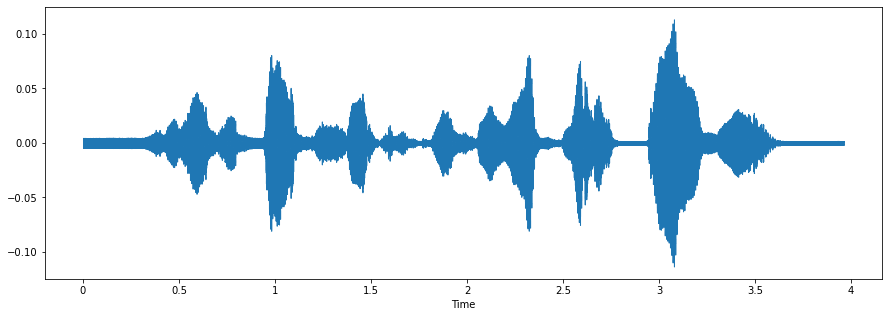

In [10]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

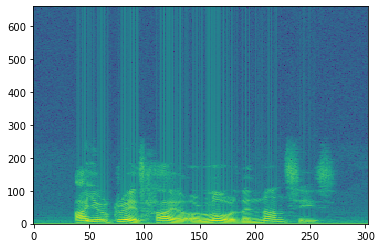

In [11]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/KL_h09.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [12]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[3]=='a':
        feeling_list.append('male_angry')
    elif item[3]=='f':
        feeling_list.append('male_fearful')
    elif item[3]=='h':
        feeling_list.append('male_happy')
    elif item[3:5]=='sa':
        feeling_list.append('male_sad')

In [13]:
print(len(feeling_list))

1200


In [14]:
labels = pd.DataFrame(feeling_list)

In [15]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [16]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][3:5]!='su' and mylist[index][3]!='n' and mylist[index][3]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [17]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.995125, -61.87015, -67.49628, ..."


In [18]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [19]:
newdf = pd.concat([df3,labels], axis=1)

In [20]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [21]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792599,-40.614017,-41.209984,-41.439613,-43.994675,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119915,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674789,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-39.072914,-41.896793,-40.866905,-38.293262,-36.375126,-37.914909,-40.027390,-43.315861,-44.848812,male_calm


In [22]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1005,-7.214671,-11.372630,-22.102346,-21.758833,-22.345116,-20.168657,-21.371592,-23.294138,-23.723398,-20.605122,...,-14.404268,-11.557772,-12.304658,-14.787576,-18.954710,-18.991243,-15.544734,-7.893218,-2.501626,male_sad
60,-50.159523,-53.069500,-57.424614,-60.286369,-63.514866,-59.823421,-59.656052,-60.265438,-60.922611,-63.632805,...,-66.580559,-65.908928,-65.688370,-59.147831,-57.583408,-60.386532,-62.520874,-63.577370,-65.219269,male_calm
286,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,...,-59.387650,-58.998447,-59.704288,-59.885624,-59.522190,-59.522190,-59.522190,-59.522190,-59.522190,male_happy
157,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,...,-61.265484,-61.317276,-60.597130,-60.337418,-62.790710,-67.382614,-69.709412,-69.842972,-69.001152,female_calm
1199,-23.740028,-24.086372,-29.539806,-29.340130,-29.448860,-29.024096,-27.539865,-27.607939,-27.730614,-27.721710,...,-42.323200,-41.650917,-43.528591,-42.910892,-41.460445,-41.764858,-42.297287,-39.512142,-33.911987,male_sad
966,-8.526944,-11.796119,-21.225157,-20.821096,-19.913889,-20.578138,-22.024477,-20.963707,-14.915606,-11.356566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_angry
948,-63.898575,-59.659790,-56.782917,-54.998940,-58.541256,-63.898575,-61.179733,-58.759148,-61.959702,-63.537148,...,-56.474529,-58.215366,-58.713921,-58.828133,-57.920189,-57.179096,-57.816326,-62.274822,-63.898575,male_fearful
458,-54.276814,-54.483963,-55.498665,-56.209129,-56.638393,-56.582008,-58.549316,-57.804691,-58.369770,-58.225040,...,-36.820030,-36.552158,-35.206833,-35.905819,-35.772190,-35.136513,-36.292519,-35.922676,-31.646231,male_sad
563,-50.077915,-49.866676,-50.077915,-49.911076,-50.008598,-50.078072,-49.785038,-49.236187,-49.006477,-47.116550,...,-38.080822,-41.300911,-42.007839,-40.983486,-43.161400,-45.158546,-44.344719,-44.239708,-44.190994,female_sad
35,-53.419655,-51.239300,-50.154289,-50.265110,-49.667740,-50.570244,-53.410641,-55.976517,-56.247890,-56.110970,...,-49.216373,-50.553242,-52.032291,-52.649040,-53.917294,-53.267586,-56.158760,-58.194771,-57.616142,female_calm


In [23]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [24]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [25]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
508,-61.116165,-61.999825,-64.303215,-65.864807,-67.256546,-62.689739,-61.315212,-61.094101,-57.842289,-56.768681,...,-61.283638,-64.084579,-62.109959,-65.042023,-67.510368,-68.390915,-71.959274,-63.999264,-57.113144,male_sad
834,-61.622707,-59.735535,-59.536018,-59.930866,-61.111374,-62.438808,-58.038921,-57.107178,-55.948074,-54.609531,...,-43.329288,-44.565422,-42.337856,-42.171837,-44.235348,-45.935318,-44.973454,-44.506657,-43.234947,male_fearful
559,-48.818810,-49.247513,-49.958858,-49.989681,-48.197552,-48.492355,-50.243614,-48.019611,-46.167690,-48.975395,...,-47.571880,-47.346661,-47.848965,-49.431274,-50.582970,-49.161797,-49.113602,-50.521233,-48.080704,female_sad
98,-31.185219,-34.449825,-46.466248,-50.427273,-50.017391,-49.716877,-49.670162,-49.205666,-50.857460,-52.709114,...,-24.641359,-25.526104,-25.465061,-25.562429,-25.281096,-25.475655,-26.474520,-25.277763,-24.493797,male_calm
683,-45.871311,-45.871311,-45.871311,-45.871311,-45.871311,-45.871311,-45.871311,-45.871311,-45.871311,-45.871311,...,-34.769577,-35.539497,-38.184402,-36.689411,-35.603439,-35.669456,-35.927063,-33.370663,-28.104778,female_angry
945,-52.135635,-50.993507,-52.111824,-53.816223,-50.711712,-49.508072,-50.742657,-51.723667,-51.633396,-52.001263,...,-38.566101,-39.543663,-39.507980,-39.207260,-38.964943,-40.820034,-41.820045,-43.116684,-40.276939,female_fearful
463,-56.789104,-55.152981,-51.760334,-51.643475,-50.939133,-53.283836,-53.651619,-53.966118,-56.716328,-57.514690,...,-53.273090,-52.861771,-52.427303,-52.244835,-53.531155,-52.978447,-51.751694,-52.355896,-55.537621,female_sad
752,-40.591553,-41.074425,-40.987331,-41.231609,-42.389503,-43.125145,-43.653130,-44.034428,-43.265640,-42.934036,...,-14.644001,-14.742428,-15.980688,-15.483383,-16.631716,-17.281696,-18.545704,-19.273409,-21.880117,male_angry
177,-55.681015,-52.768211,-53.520267,-54.932835,-55.330276,-54.357639,-54.875313,-55.921280,-52.163029,-50.481159,...,-36.638645,-38.412830,-37.785679,-39.638531,-42.478706,-42.427303,-43.424480,-43.380295,-43.638206,female_calm
231,-56.115513,-56.115513,-56.115513,-56.115513,-56.115513,-56.115513,-56.115513,-56.115513,-56.115513,-56.115513,...,-49.817307,-53.152767,-50.878826,-51.290668,-51.298912,-53.193424,-52.802139,-50.201454,-51.668255,female_happy


In [26]:
trainfeatures = train.iloc[:, :-1]

In [27]:
trainlabel = train.iloc[:, -1:]

In [28]:
testfeatures = test.iloc[:, :-1]

In [29]:
testlabel = test.iloc[:, -1:]

In [30]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\beast\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [32]:
X_train.shape

(955, 216)

In [33]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Changing dimension for CNN model

In [34]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [34]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1536      
                                                                 
 activation_5 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_6 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Training part

In [37]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
59/59 [==============================] - 4s 52ms/step - loss: 2.4229 - accuracy: 0.0900 - val_loss: 2.3559 - val_accuracy: 0.1124
Epoch 2/700
59/59 [==============================] - 3s 47ms/step - loss: 2.3134 - accuracy: 0.1286 - val_loss: 2.3119 - val_accuracy: 0.1273
Epoch 3/700
59/59 [==============================] - 3s 48ms/step - loss: 2.2834 - accuracy: 0.1426 - val_loss: 2.2696 - val_accuracy: 0.1798
Epoch 4/700
59/59 [==============================] - 3s 48ms/step - loss: 2.2458 - accuracy: 0.1576 - val_loss: 2.2481 - val_accuracy: 0.2022
Epoch 5/700
59/59 [==============================] - 3s 49ms/step - loss: 2.2227 - accuracy: 0.1683 - val_loss: 2.2357 - val_accuracy: 0.1873
Epoch 6/700
59/59 [==============================] - 3s 48ms/step - loss: 2.1968 - accuracy: 0.1726 - val_loss: 2.2071 - val_accuracy: 0.1910
Epoch 7/700
59/59 [==============================] - 4s 60ms/step - loss: 2.1690 - accuracy: 0.1929 - val_loss: 2.1911 - val_accuracy: 0.2135
Epoch 

59/59 [==============================] - 5s 85ms/step - loss: 1.1680 - accuracy: 0.5981 - val_loss: 1.5082 - val_accuracy: 0.4007
Epoch 116/700
59/59 [==============================] - 5s 89ms/step - loss: 1.1545 - accuracy: 0.6024 - val_loss: 1.4969 - val_accuracy: 0.4270
Epoch 117/700
59/59 [==============================] - 5s 85ms/step - loss: 1.1626 - accuracy: 0.5927 - val_loss: 1.4778 - val_accuracy: 0.4232
Epoch 118/700
59/59 [==============================] - 5s 85ms/step - loss: 1.1527 - accuracy: 0.5895 - val_loss: 1.5004 - val_accuracy: 0.3933
Epoch 119/700
59/59 [==============================] - 5s 85ms/step - loss: 1.1462 - accuracy: 0.5831 - val_loss: 1.4830 - val_accuracy: 0.4082
Epoch 120/700
59/59 [==============================] - 5s 87ms/step - loss: 1.1420 - accuracy: 0.5831 - val_loss: 1.5737 - val_accuracy: 0.4270
Epoch 121/700
59/59 [==============================] - 5s 87ms/step - loss: 1.1395 - accuracy: 0.5959 - val_loss: 1.7631 - val_accuracy: 0.3371
Epoch 

Epoch 172/700
59/59 [==============================] - 5s 84ms/step - loss: 0.9839 - accuracy: 0.6517 - val_loss: 1.4821 - val_accuracy: 0.4157
Epoch 173/700
59/59 [==============================] - 5s 85ms/step - loss: 0.9759 - accuracy: 0.6720 - val_loss: 1.5500 - val_accuracy: 0.4232
Epoch 174/700
59/59 [==============================] - 5s 85ms/step - loss: 0.9840 - accuracy: 0.6592 - val_loss: 1.4456 - val_accuracy: 0.4457
Epoch 175/700
59/59 [==============================] - 5s 84ms/step - loss: 0.9706 - accuracy: 0.6635 - val_loss: 1.4579 - val_accuracy: 0.4494
Epoch 176/700
59/59 [==============================] - 5s 84ms/step - loss: 0.9622 - accuracy: 0.6506 - val_loss: 1.4764 - val_accuracy: 0.4270
Epoch 177/700
59/59 [==============================] - 5s 84ms/step - loss: 0.9694 - accuracy: 0.6581 - val_loss: 1.4705 - val_accuracy: 0.4307
Epoch 178/700
59/59 [==============================] - 5s 84ms/step - loss: 0.9677 - accuracy: 0.6613 - val_loss: 1.4583 - val_accuracy:

Epoch 229/700
59/59 [==============================] - 5s 83ms/step - loss: 0.8363 - accuracy: 0.7170 - val_loss: 1.4405 - val_accuracy: 0.4644
Epoch 230/700
59/59 [==============================] - 5s 83ms/step - loss: 0.8355 - accuracy: 0.7138 - val_loss: 1.5020 - val_accuracy: 0.4232
Epoch 231/700
59/59 [==============================] - 5s 84ms/step - loss: 0.8261 - accuracy: 0.7299 - val_loss: 1.4721 - val_accuracy: 0.4532
Epoch 232/700
59/59 [==============================] - 5s 83ms/step - loss: 0.8300 - accuracy: 0.7192 - val_loss: 1.4585 - val_accuracy: 0.4569
Epoch 233/700
59/59 [==============================] - 5s 83ms/step - loss: 0.8217 - accuracy: 0.7235 - val_loss: 1.4728 - val_accuracy: 0.4569
Epoch 234/700
59/59 [==============================] - 5s 86ms/step - loss: 0.8169 - accuracy: 0.7149 - val_loss: 1.5004 - val_accuracy: 0.4494
Epoch 235/700
59/59 [==============================] - 5s 88ms/step - loss: 0.8224 - accuracy: 0.7224 - val_loss: 1.4858 - val_accuracy:

Epoch 286/700
59/59 [==============================] - 5s 89ms/step - loss: 0.7117 - accuracy: 0.7631 - val_loss: 1.5970 - val_accuracy: 0.4457
Epoch 287/700
59/59 [==============================] - 5s 87ms/step - loss: 0.7071 - accuracy: 0.7738 - val_loss: 1.4893 - val_accuracy: 0.4906
Epoch 288/700
59/59 [==============================] - 5s 80ms/step - loss: 0.7040 - accuracy: 0.7781 - val_loss: 1.5365 - val_accuracy: 0.4569
Epoch 289/700
59/59 [==============================] - 5s 81ms/step - loss: 0.6969 - accuracy: 0.7728 - val_loss: 1.5026 - val_accuracy: 0.4682
Epoch 290/700
59/59 [==============================] - 5s 79ms/step - loss: 0.6980 - accuracy: 0.7760 - val_loss: 1.4947 - val_accuracy: 0.4607
Epoch 291/700
59/59 [==============================] - 5s 80ms/step - loss: 0.6960 - accuracy: 0.7814 - val_loss: 1.5763 - val_accuracy: 0.4045
Epoch 292/700
59/59 [==============================] - 5s 80ms/step - loss: 0.6958 - accuracy: 0.7696 - val_loss: 1.4758 - val_accuracy:

Epoch 343/700
59/59 [==============================] - 5s 82ms/step - loss: 0.5951 - accuracy: 0.8199 - val_loss: 1.6025 - val_accuracy: 0.4532
Epoch 344/700
59/59 [==============================] - 5s 81ms/step - loss: 0.5892 - accuracy: 0.8081 - val_loss: 1.5661 - val_accuracy: 0.4607
Epoch 345/700
59/59 [==============================] - 5s 80ms/step - loss: 0.5842 - accuracy: 0.8232 - val_loss: 1.6362 - val_accuracy: 0.4382
Epoch 346/700
59/59 [==============================] - 5s 80ms/step - loss: 0.5767 - accuracy: 0.8081 - val_loss: 1.5304 - val_accuracy: 0.4494
Epoch 347/700
59/59 [==============================] - 5s 81ms/step - loss: 0.5786 - accuracy: 0.8114 - val_loss: 1.6293 - val_accuracy: 0.4569
Epoch 348/700
59/59 [==============================] - 5s 80ms/step - loss: 0.5790 - accuracy: 0.8189 - val_loss: 1.5472 - val_accuracy: 0.4270
Epoch 349/700
59/59 [==============================] - 5s 81ms/step - loss: 0.5742 - accuracy: 0.8232 - val_loss: 1.5549 - val_accuracy:

Epoch 400/700
59/59 [==============================] - 5s 80ms/step - loss: 0.4890 - accuracy: 0.8564 - val_loss: 1.6586 - val_accuracy: 0.4082
Epoch 401/700
59/59 [==============================] - 5s 80ms/step - loss: 0.4787 - accuracy: 0.8596 - val_loss: 1.6132 - val_accuracy: 0.4457
Epoch 402/700
59/59 [==============================] - 5s 80ms/step - loss: 0.4795 - accuracy: 0.8628 - val_loss: 1.5877 - val_accuracy: 0.4419
Epoch 403/700
59/59 [==============================] - 5s 79ms/step - loss: 0.4747 - accuracy: 0.8607 - val_loss: 1.6008 - val_accuracy: 0.4494
Epoch 404/700
59/59 [==============================] - 5s 80ms/step - loss: 0.4815 - accuracy: 0.8553 - val_loss: 1.6253 - val_accuracy: 0.4382
Epoch 405/700
59/59 [==============================] - 5s 82ms/step - loss: 0.4809 - accuracy: 0.8585 - val_loss: 1.6271 - val_accuracy: 0.4307
Epoch 406/700
59/59 [==============================] - 5s 80ms/step - loss: 0.4754 - accuracy: 0.8607 - val_loss: 1.7356 - val_accuracy:

Epoch 457/700
59/59 [==============================] - 5s 85ms/step - loss: 0.3877 - accuracy: 0.8907 - val_loss: 1.6825 - val_accuracy: 0.4494
Epoch 458/700
59/59 [==============================] - 5s 83ms/step - loss: 0.3887 - accuracy: 0.8950 - val_loss: 1.7322 - val_accuracy: 0.4532
Epoch 459/700
59/59 [==============================] - 5s 83ms/step - loss: 0.3797 - accuracy: 0.8917 - val_loss: 1.7584 - val_accuracy: 0.4682
Epoch 460/700
59/59 [==============================] - 5s 85ms/step - loss: 0.3800 - accuracy: 0.8928 - val_loss: 1.7698 - val_accuracy: 0.4195
Epoch 461/700
59/59 [==============================] - 5s 84ms/step - loss: 0.3838 - accuracy: 0.8992 - val_loss: 1.7184 - val_accuracy: 0.4157
Epoch 462/700
59/59 [==============================] - 5s 84ms/step - loss: 0.3790 - accuracy: 0.9003 - val_loss: 1.7800 - val_accuracy: 0.4270
Epoch 463/700
59/59 [==============================] - 5s 84ms/step - loss: 0.3796 - accuracy: 0.8917 - val_loss: 1.7415 - val_accuracy:

Epoch 514/700
59/59 [==============================] - 5s 83ms/step - loss: 0.2898 - accuracy: 0.9357 - val_loss: 1.8661 - val_accuracy: 0.4045
Epoch 515/700
59/59 [==============================] - 5s 87ms/step - loss: 0.2875 - accuracy: 0.9282 - val_loss: 1.8670 - val_accuracy: 0.4082
Epoch 516/700
59/59 [==============================] - 5s 84ms/step - loss: 0.2894 - accuracy: 0.9260 - val_loss: 1.8389 - val_accuracy: 0.4307
Epoch 517/700
59/59 [==============================] - 5s 85ms/step - loss: 0.2881 - accuracy: 0.9411 - val_loss: 1.8610 - val_accuracy: 0.4457
Epoch 518/700
59/59 [==============================] - 5s 84ms/step - loss: 0.2898 - accuracy: 0.9346 - val_loss: 1.8440 - val_accuracy: 0.4045
Epoch 519/700
59/59 [==============================] - 5s 84ms/step - loss: 0.2855 - accuracy: 0.9260 - val_loss: 1.8598 - val_accuracy: 0.4270
Epoch 520/700
59/59 [==============================] - 5s 83ms/step - loss: 0.2841 - accuracy: 0.9368 - val_loss: 1.8612 - val_accuracy:

Epoch 571/700
59/59 [==============================] - 5s 84ms/step - loss: 0.2079 - accuracy: 0.9614 - val_loss: 2.0450 - val_accuracy: 0.3933
Epoch 572/700
59/59 [==============================] - 5s 85ms/step - loss: 0.2120 - accuracy: 0.9561 - val_loss: 2.0082 - val_accuracy: 0.4045
Epoch 573/700
59/59 [==============================] - 5s 84ms/step - loss: 0.2057 - accuracy: 0.9571 - val_loss: 2.0434 - val_accuracy: 0.4007
Epoch 574/700
59/59 [==============================] - 5s 86ms/step - loss: 0.2006 - accuracy: 0.9625 - val_loss: 1.9891 - val_accuracy: 0.4607
Epoch 575/700
59/59 [==============================] - 5s 85ms/step - loss: 0.2074 - accuracy: 0.9603 - val_loss: 1.9830 - val_accuracy: 0.4494
Epoch 576/700
59/59 [==============================] - 5s 85ms/step - loss: 0.2009 - accuracy: 0.9603 - val_loss: 2.0501 - val_accuracy: 0.4532
Epoch 577/700
59/59 [==============================] - 5s 84ms/step - loss: 0.2014 - accuracy: 0.9593 - val_loss: 1.9735 - val_accuracy:

Epoch 628/700
59/59 [==============================] - 5s 84ms/step - loss: 0.1382 - accuracy: 0.9786 - val_loss: 2.1885 - val_accuracy: 0.4494
Epoch 629/700
59/59 [==============================] - 5s 88ms/step - loss: 0.1373 - accuracy: 0.9786 - val_loss: 2.1795 - val_accuracy: 0.4270
Epoch 630/700
59/59 [==============================] - 5s 84ms/step - loss: 0.1343 - accuracy: 0.9807 - val_loss: 2.1938 - val_accuracy: 0.4419
Epoch 631/700
59/59 [==============================] - 5s 84ms/step - loss: 0.1363 - accuracy: 0.9807 - val_loss: 2.2081 - val_accuracy: 0.4120
Epoch 632/700
59/59 [==============================] - 5s 84ms/step - loss: 0.1359 - accuracy: 0.9818 - val_loss: 2.2680 - val_accuracy: 0.4157
Epoch 633/700
59/59 [==============================] - 5s 88ms/step - loss: 0.1321 - accuracy: 0.9850 - val_loss: 2.2081 - val_accuracy: 0.4195
Epoch 634/700
59/59 [==============================] - 5s 84ms/step - loss: 0.1375 - accuracy: 0.9775 - val_loss: 2.2057 - val_accuracy:

Epoch 685/700
59/59 [==============================] - 5s 86ms/step - loss: 0.0840 - accuracy: 0.9957 - val_loss: 2.4893 - val_accuracy: 0.4195
Epoch 686/700
59/59 [==============================] - 5s 85ms/step - loss: 0.0845 - accuracy: 0.9946 - val_loss: 2.4357 - val_accuracy: 0.4157
Epoch 687/700
59/59 [==============================] - 5s 84ms/step - loss: 0.0808 - accuracy: 0.9925 - val_loss: 2.4746 - val_accuracy: 0.4607
Epoch 688/700
59/59 [==============================] - 5s 88ms/step - loss: 0.0803 - accuracy: 0.9968 - val_loss: 2.4086 - val_accuracy: 0.4419
Epoch 689/700
59/59 [==============================] - 5s 83ms/step - loss: 0.0839 - accuracy: 0.9925 - val_loss: 2.5249 - val_accuracy: 0.4382
Epoch 690/700
59/59 [==============================] - 5s 87ms/step - loss: 0.0819 - accuracy: 0.9914 - val_loss: 2.4149 - val_accuracy: 0.4457
Epoch 691/700
59/59 [==============================] - 5s 93ms/step - loss: 0.0752 - accuracy: 0.9968 - val_loss: 2.4857 - val_accuracy:

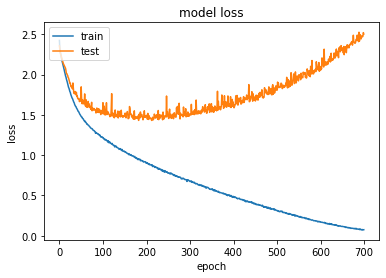

In [38]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [39]:
model_name = 'Emotion_Voice_Detection_Model1.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\beast\Documents\New folder\Speech-Emotion-Analyzer-master\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model1.h5 


In [40]:
import json
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [35]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


C:\Users\beast\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


accuracy: 91.84%


## Predicting emotions on the test data

In [36]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

8/8 [==============================] - 0s 16ms/step


In [37]:
preds

array([[3.31404037e-03, 6.10855281e-01, 6.80603844e-04, ...,
        5.36582434e-07, 1.76098339e-07, 3.52874515e-04],
       [1.04783076e-07, 4.73910163e-28, 4.97965003e-11, ...,
        1.06827383e-06, 9.29088742e-07, 9.99919295e-01],
       [7.55727355e-19, 7.27182426e-37, 1.54081501e-20, ...,
        5.35151194e-05, 5.44584918e-06, 3.54813557e-04],
       ...,
       [9.63774920e-01, 3.12236547e-02, 2.18258810e-05, ...,
        3.32660238e-05, 1.08193250e-04, 1.03186793e-03],
       [3.01507185e-04, 5.78849690e-10, 3.61880773e-13, ...,
        6.11503317e-04, 8.34294975e-01, 1.44013554e-01],
       [2.67663513e-11, 1.37384554e-19, 2.23192361e-16, ...,
        1.08423635e-07, 7.46456180e-07, 9.97337401e-01]], dtype=float32)

In [38]:
preds1=preds.argmax(axis=1)

In [39]:
preds1

array([1, 9, 5, 8, 9, 0, 3, 4, 7, 2, 0, 3, 5, 2, 2, 1, 5, 1, 8, 2, 8, 8,
       1, 7, 1, 9, 5, 1, 2, 4, 4, 8, 3, 9, 1, 9, 2, 4, 2, 9, 9, 7, 9, 7,
       6, 8, 9, 9, 3, 5, 9, 1, 0, 4, 4, 0, 9, 9, 9, 6, 5, 8, 9, 8, 6, 9,
       7, 5, 7, 2, 1, 6, 1, 8, 5, 7, 8, 3, 1, 8, 9, 8, 7, 8, 5, 1, 2, 7,
       5, 2, 7, 2, 2, 2, 9, 1, 6, 2, 4, 9, 3, 1, 6, 7, 1, 9, 8, 9, 0, 4,
       2, 1, 9, 9, 3, 4, 1, 5, 6, 2, 7, 8, 6, 1, 7, 7, 3, 0, 6, 2, 7, 4,
       5, 3, 3, 5, 8, 3, 8, 0, 8, 9, 2, 8, 7, 1, 9, 8, 8, 2, 6, 7, 6, 5,
       4, 0, 7, 7, 1, 7, 7, 9, 5, 8, 7, 9, 7, 9, 8, 9, 8, 2, 9, 7, 8, 7,
       5, 9, 1, 9, 6, 5, 7, 0, 9, 5, 5, 1, 7, 6, 2, 4, 5, 5, 8, 8, 6, 4,
       5, 3, 5, 0, 0, 1, 9, 9, 8, 4, 5, 3, 0, 4, 5, 7, 9, 3, 9, 8, 5, 7,
       6, 3, 4, 4, 2, 3, 9, 6, 3, 3, 5, 6, 9, 5, 4, 1, 9, 7, 8, 5, 3, 9,
       0, 8, 9], dtype=int64)

In [40]:
actual=y_test.argmax(axis=1)
actual

array([1, 9, 5, 8, 9, 7, 3, 4, 7, 2, 0, 3, 5, 2, 2, 1, 5, 1, 8, 2, 8, 8,
       1, 7, 4, 7, 5, 4, 2, 1, 4, 6, 3, 9, 1, 9, 2, 4, 2, 9, 7, 7, 6, 7,
       6, 8, 9, 9, 3, 5, 9, 1, 0, 4, 4, 0, 9, 9, 9, 6, 5, 8, 9, 8, 6, 9,
       7, 5, 7, 2, 1, 6, 1, 8, 5, 7, 8, 3, 1, 8, 9, 8, 7, 8, 5, 3, 2, 7,
       5, 0, 7, 2, 2, 2, 9, 1, 6, 2, 4, 9, 3, 1, 1, 7, 1, 9, 8, 9, 0, 4,
       2, 1, 9, 9, 3, 4, 1, 5, 6, 2, 7, 8, 6, 4, 7, 7, 3, 0, 6, 2, 7, 4,
       7, 3, 3, 5, 8, 3, 8, 0, 8, 9, 2, 8, 7, 1, 9, 8, 8, 2, 6, 7, 9, 5,
       4, 0, 7, 7, 1, 7, 7, 9, 5, 8, 7, 6, 7, 9, 8, 9, 8, 2, 9, 7, 8, 7,
       5, 9, 1, 9, 6, 7, 7, 0, 9, 5, 8, 1, 7, 9, 0, 4, 5, 5, 8, 8, 6, 4,
       5, 3, 5, 2, 0, 1, 9, 9, 8, 4, 5, 3, 0, 4, 5, 7, 9, 3, 9, 8, 5, 7,
       6, 3, 4, 4, 2, 3, 9, 6, 3, 3, 5, 6, 9, 5, 4, 1, 9, 7, 8, 5, 3, 9,
       0, 8, 9], dtype=int64)

In [41]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(actual, preds1))

[[11  0  2  0  0  0  0  0  0  0]
 [ 0 20  0  0  1  0  1  0  0  0]
 [ 1  0 20  0  0  0  0  0  0  0]
 [ 0  1  0 19  0  0  0  0  0  0]
 [ 0  3  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  1  2]
 [ 1  0  0  0  0  2  0 30  0  2]
 [ 0  0  0  0  0  1  0  0 30  0]
 [ 0  0  0  0  0  0  2  0  0 38]]


In [42]:
from sklearn.metrics import classification_report

print(classification_report(actual, preds1))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.83      0.91      0.87        22
           2       0.91      0.95      0.93        21
           3       1.00      0.95      0.97        20
           4       0.94      0.85      0.89        20
           5       0.90      1.00      0.95        26
           6       0.82      0.82      0.82        17
           7       1.00      0.86      0.92        35
           8       0.97      0.97      0.97        31
           9       0.90      0.95      0.93        40

    accuracy                           0.92       245
   macro avg       0.91      0.91      0.91       245
weighted avg       0.92      0.92      0.92       245



In [43]:
abc = preds1.astype(int).flatten()

In [44]:
predictions = (lb.inverse_transform((abc)))

In [45]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [46]:
print(confusion_matrix(actualvalues, predictions))

[[11  0  2  0  0  0  0  0  0  0]
 [ 0 20  0  0  1  0  1  0  0  0]
 [ 1  0 20  0  0  0  0  0  0  0]
 [ 0  1  0 19  0  0  0  0  0  0]
 [ 0  3  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  1  2]
 [ 1  0  0  0  0  2  0 30  0  2]
 [ 0  0  0  0  0  1  0  0 30  0]
 [ 0  0  0  0  0  0  2  0  0 38]]


In [47]:
print(classification_report(actualvalues, predictions))

                precision    recall  f1-score   support

  female_angry       0.85      0.85      0.85        13
   female_calm       0.83      0.91      0.87        22
female_fearful       0.91      0.95      0.93        21
  female_happy       1.00      0.95      0.97        20
    female_sad       0.94      0.85      0.89        20
    male_angry       0.90      1.00      0.95        26
     male_calm       0.82      0.82      0.82        17
  male_fearful       1.00      0.86      0.92        35
    male_happy       0.97      0.97      0.97        31
      male_sad       0.90      0.95      0.93        40

      accuracy                           0.92       245
     macro avg       0.91      0.91      0.91       245
  weighted avg       0.92      0.92      0.92       245



## Actual v/s Predicted emotions

In [45]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_fearful,male_fearful
171,male_calm,male_calm
172,male_angry,male_angry
173,female_angry,female_angry
174,male_happy,male_happy
175,male_fearful,male_fearful
176,female_sad,female_sad
177,male_fearful,male_sad
178,female_angry,female_angry
179,female_angry,female_angry


In [46]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,19
female_calm,22
female_fearful,23
female_happy,17
female_sad,16
male_angry,28
male_calm,15
male_fearful,38
male_happy,22


In [47]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,21
female_calm,22
female_fearful,24
female_happy,16
female_sad,15
male_angry,28
male_calm,19
male_fearful,36
male_happy,21


In [48]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

In [48]:
import pandas as pd

In [49]:
data, sampling_rate = librosa.load('output12.wav')

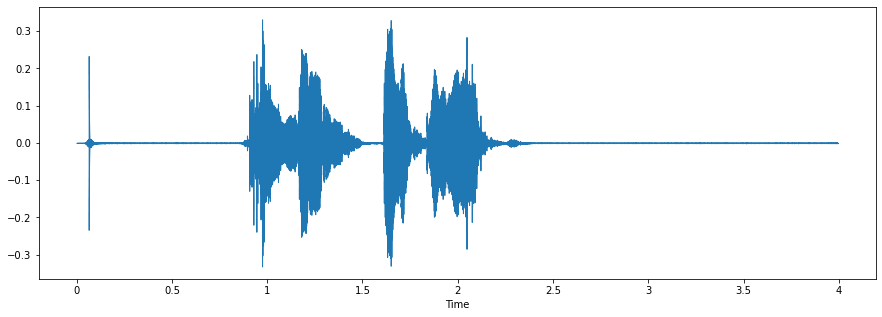

In [50]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [71]:
X, sample_rate = librosa.load('output13.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [72]:
livedf2= pd.DataFrame(data=livedf2)

In [73]:
livedf2 = livedf2.stack().to_frame().T

In [74]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-44.217934,-42.260124,-40.976604,-42.304138,-42.405373,-42.012936,-41.533264,-43.738121,-43.913288,-41.740086,...,-41.162987,-42.527203,-40.95573,-39.634514,-41.071552,-40.994282,-41.321041,-42.650394,-41.261902,-42.738773


In [75]:
twodim= np.expand_dims(livedf2, axis=2)

In [76]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 32ms/step


In [77]:
livepreds

array([[3.2353844e-18, 4.7541979e-25, 2.1969441e-24, 7.3286399e-18,
        1.3603631e-22, 1.3718103e-02, 9.6714690e-09, 2.5983685e-01,
        6.7690539e-01, 4.9539682e-02]], dtype=float32)

In [78]:
livepreds1=livepreds.argmax(axis=1)

In [79]:
liveabc = livepreds1.astype(int).flatten()

In [80]:
livepredictions = (lb.inverse_transform((liveabc)))
print(livepredictions[0])

male_happy


### Direct prediction

In [38]:
import pyaudio
import wave

In [53]:
CHUNK = 1024 
FORMAT = pyaudio.paInt16 
CHANNELS = 2 
RATE = 44100 
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output14.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) 

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()
X, sample_rate = librosa.load('output14.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
twodim= np.expand_dims(livedf2, axis=2)
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))
print(livepredictions[0])

* recording
* done recording
1/1 [==============================] - 0s 18ms/step


array(['male_angry'], dtype=object)